In [41]:
import os

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graspy as gs

import sys
sys.path.append("../../multigraph/")

from experiment import MultiGraphCluster

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_scatter(X, Y, xlabel = False, ylabel=False, title=None):
    with sns.plotting_context("talk", font_scale=1):
        fig = plt.figure(figsize=(10, 6))
        plot = sns.scatterplot(X, Y)
        plot.set(xlabel=xlabel, ylabel=ylabel, title=title)
    return plot

In [3]:
fmri_path = '../../data/HNU1/fmri/desikan/'
fmris = os.listdir(fmri_path)

dmri_path = '../../data/HNU1/dwi/desikan/'
dmris = os.listdir(dmri_path)

df = pd.read_csv('../../data/HNU1/subject_data.csv')

In [4]:
age = df['age'].values.reshape(-1, 1)
sex = df['sex'].values.reshape(-1, 1)

In [5]:
dmri_graphs = []
fmri_graphs = []
labels = []

for idx, row in df.iterrows():
    dmri_file, fmri_file, label, _ ,_ = row
    dmri_graphs.append(gs.utils.import_graph(np.load(dmri_path + dmri_file)))
    fmri_graphs.append(gs.utils.import_graph(np.load(fmri_path + fmri_file)))
    labels.append(label)

In [6]:
len(dmri_graphs)

274

## Multimodal, multigraph clustering

### HNU1 Dataset

Data summary
- subjects = 30
- total fmri scans = 274
- total dmri scans = 274
- total scans = 548

Desikan atlas
- num vertices = 70

## WIth PTR

In [7]:
dmri_ptr = [gs.utils.pass_to_ranks(g) for g in dmri_graphs]
fmri_ptr = [gs.utils.pass_to_ranks(g) for g in fmri_graphs]

In [8]:
omni = gs.embed.OmnibusEmbed(n_components=50)
Zhat_dmri = omni.fit_transform(dmri_ptr)
omni = gs.embed.OmnibusEmbed(n_components=50)
Zhat_fmri = omni.fit_transform(fmri_ptr)

In [9]:
Zhat = np.hstack([Zhat_dmri, Zhat_fmri])
print(Zhat.shape)

(19180, 100)


In [10]:
Zhat = Zhat.reshape((274, 70, -1))

In [11]:
cmds = gs.embed.ClassicalMDS(n_components=20)
Xhat = cmds.fit_transform(Zhat)

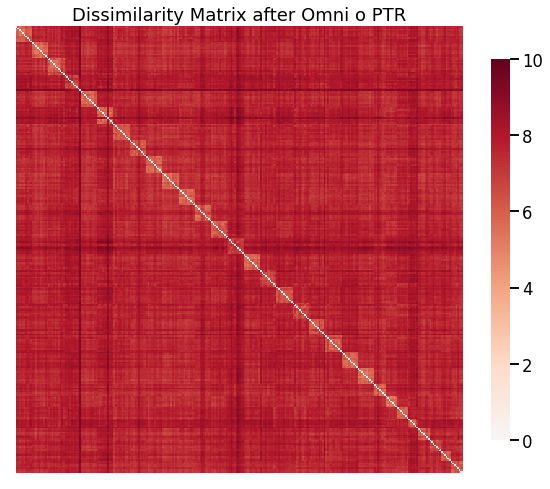

In [12]:
gs.plot.heatmap(cmds.dissimilarity_matrix_, title='Dissimilarity Matrix after Omni o PTR')

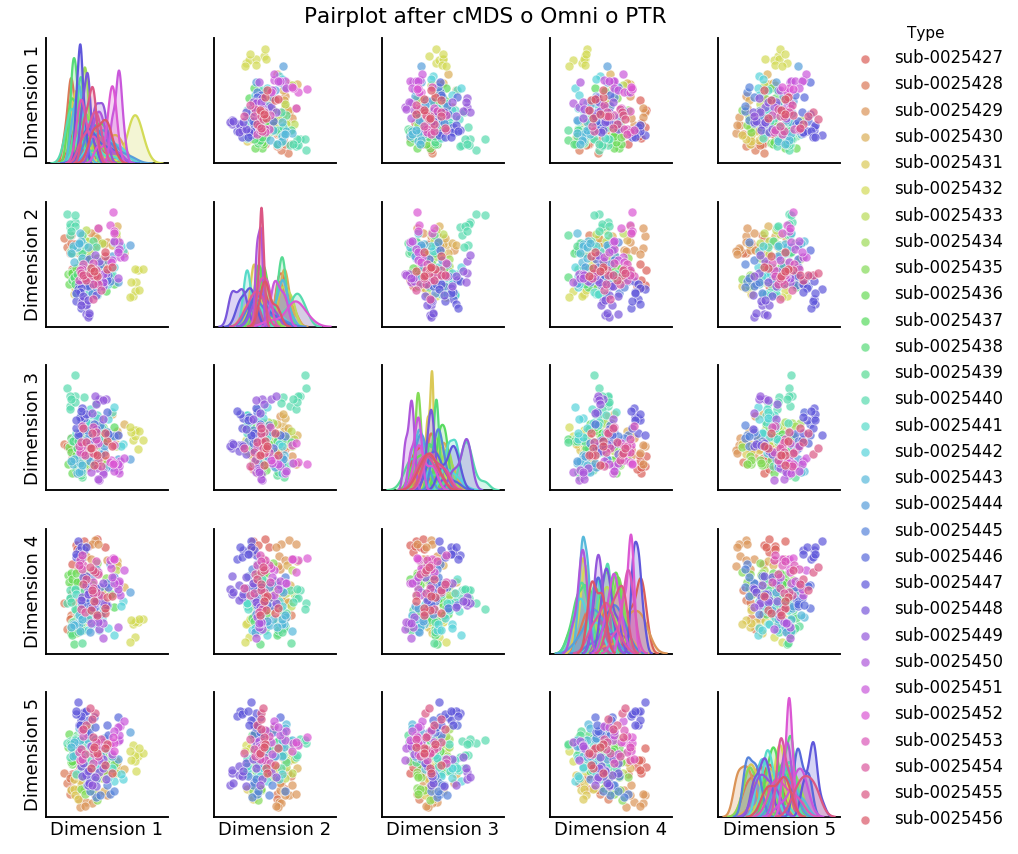

In [13]:
variables = ['Dimension {}'.format(i) for i in range(1, Xhat.shape[1] + 1)]

gs.plot.pairplot(Xhat, Y=labels, palette='hls', col_names=variables, variables=variables[:5], 
                 title='Pairplot after cMDS o Omni o PTR')

### Running MGC on embeddings from cMDS and subject labels

In [28]:
from mgcpy.independence_tests.mgc.mgc import MGC

In [29]:
mgc_independence = MGC(Xhat, age.astype(float), None)
pval, data = mgc_independence.p_value()

In [30]:
pval

0.0

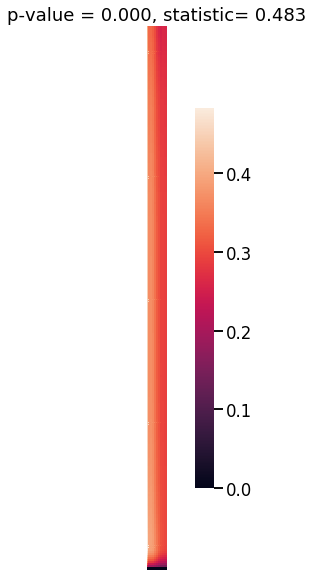

In [31]:
corr_matrix = data['local_correlation_matrix']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot = sns.heatmap(np.flipud(corr_matrix), ax=ax, square=True, cbar_kws = dict(shrink=0.7), xticklabels=False,
            yticklabels=False)
    plot.set_title('p-value = {:.3f}, statistic= {:.3f}'.format(pval, data['test_statistic']))

In [14]:
Xhat.shape

(274, 20)

In [15]:
gclust = gs.cluster.GaussianCluster(50)
gclust.fit(Xhat, labels)

GaussianCluster(covariance_type='full', max_components=50, random_state=None)

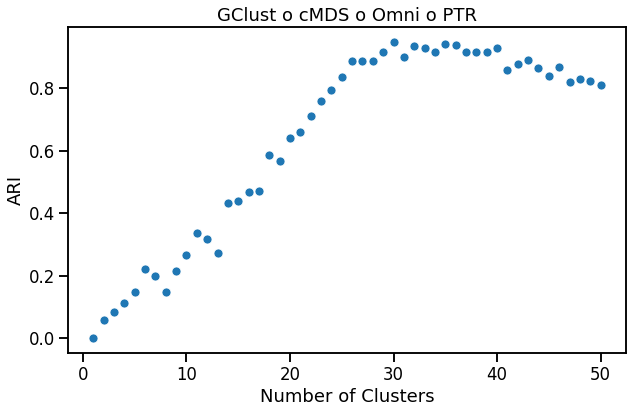

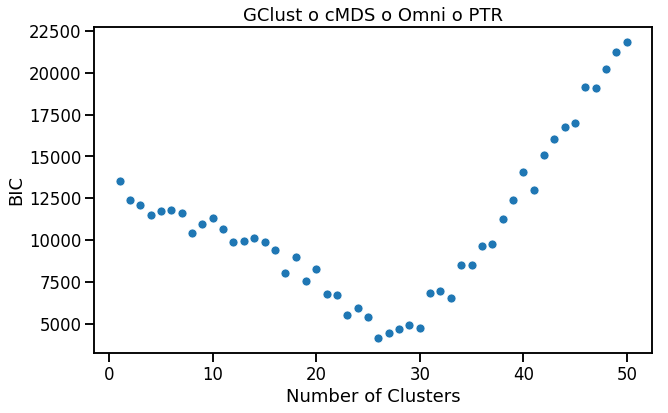

In [16]:
plot_scatter(np.arange(1, 51), gclust.ari_, ylabel='ARI', xlabel='Number of Clusters', title='GClust o cMDS o Omni o PTR')

plot_scatter(np.arange(1, 51), gclust.bic_, ylabel='BIC', xlabel='Number of Clusters', title='GClust o cMDS o Omni o PTR')

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
age = age.reshape(-1, 1)

In [19]:
lr = LinearRegression()

lr.fit(age, Xhat)

X_regressed = Xhat - lr.predict(age)

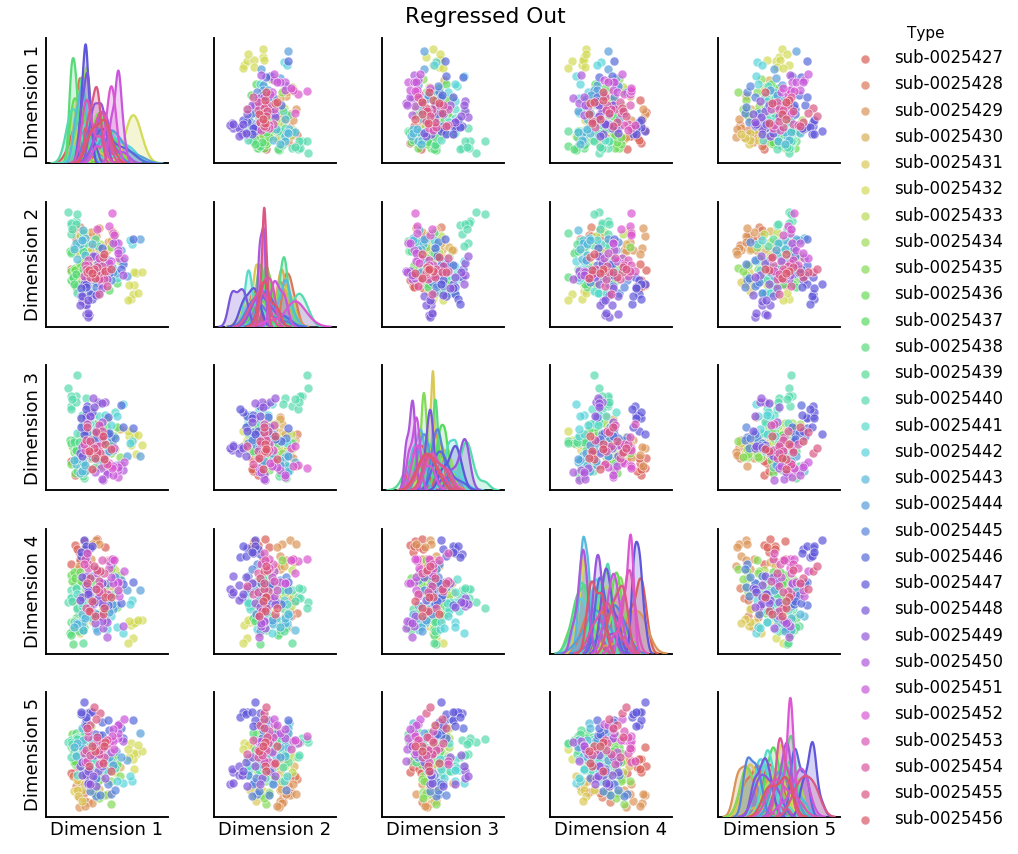

In [21]:
gs.plot.pairplot(X_regressed, Y = labels, col_names=variables, variables=variables[:5], title = 'Regressed Out', palette='hls')

In [32]:
mgc_independence = MGC(X_regressed, age.astype(float), None)
pval, data = mgc_independence.p_value()

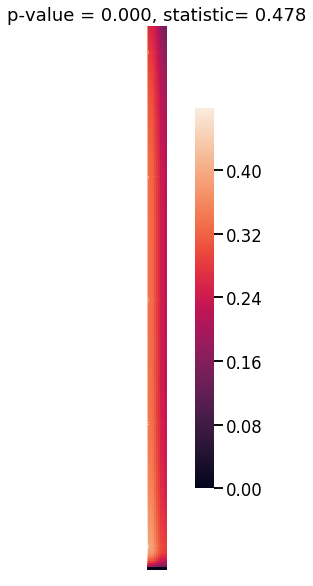

In [33]:
corr_matrix = data['local_correlation_matrix']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot = sns.heatmap(np.flipud(corr_matrix), ax=ax, square=True, cbar_kws = dict(shrink=0.7), xticklabels=False,
            yticklabels=False)
    plot.set_title('p-value = {:.3f}, statistic= {:.3f}'.format(pval, data['test_statistic']))

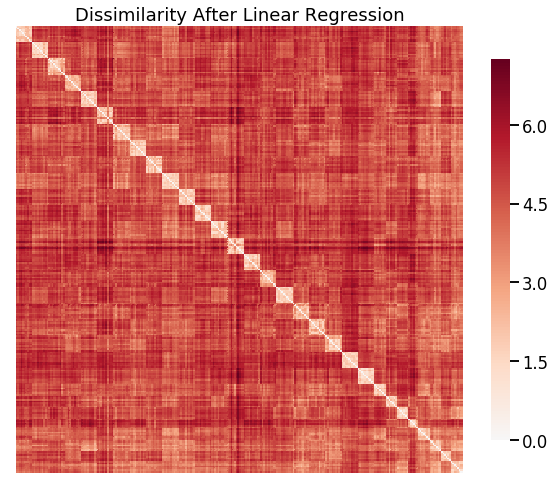

In [87]:
cmds = gs.embed.ClassicalMDS()
cmds.fit(X_regressed)

gs.plot.heatmap(cmds.dissimilarity_matrix_, title='Dissimilarity After Linear Regression')

In [26]:
gclust = gs.cluster.GaussianCluster(50)
gclust.fit(X_regressed, labels)

GaussianCluster(covariance_type='full', max_components=50, random_state=None)

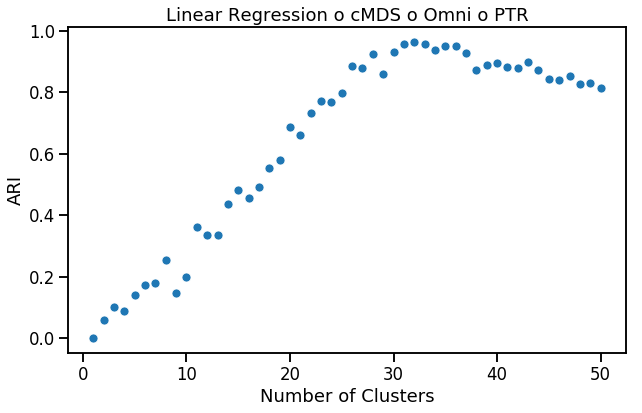

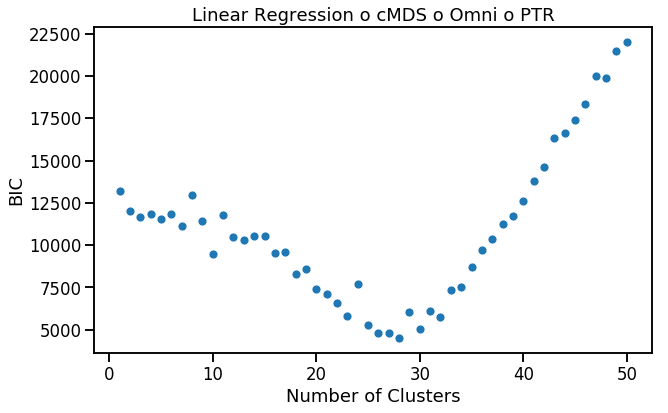

In [27]:
plot_scatter(np.arange(1, 51), gclust.ari_, ylabel='ARI', xlabel='Number of Clusters', title = 'Linear Regression o cMDS o Omni o PTR')

plot_scatter(np.arange(1, 51), gclust.bic_, ylabel='BIC', xlabel='Number of Clusters', title = 'Linear Regression o cMDS o Omni o PTR')

## Try RF Regression

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
rf = RandomForestRegressor(n_estimators=500)

rf.fit(age, Xhat)

X_rf_regress = Xhat - rf.predict(age)

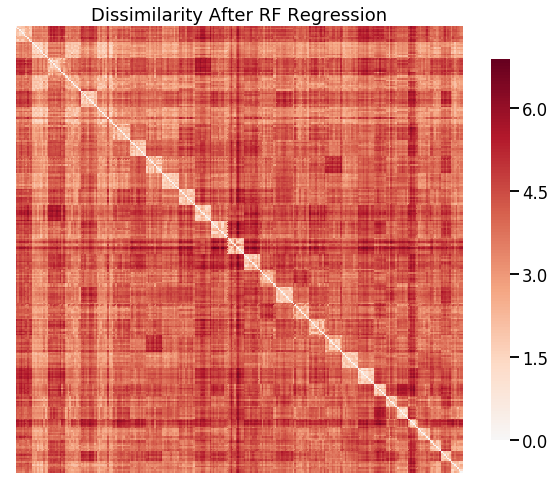

In [91]:
cmds = gs.embed.ClassicalMDS()
cmds.fit(X_rf_regress)

gs.plot.heatmap(cmds.dissimilarity_matrix_, title='Dissimilarity After RF Regression')

In [42]:
gclust = gs.cluster.GaussianCluster(50)
gclust.fit(X_rf_regress, labels)

GaussianCluster(covariance_type='full', max_components=50, random_state=None)

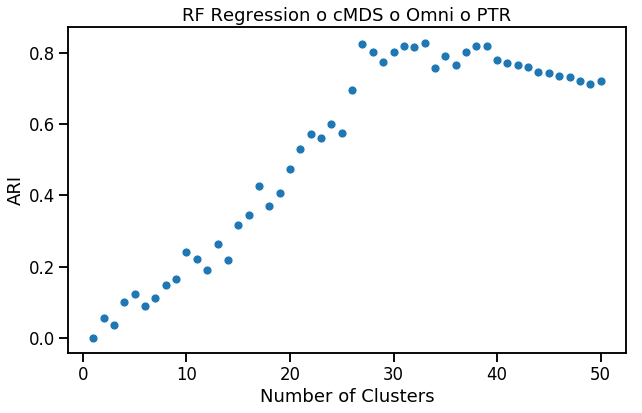

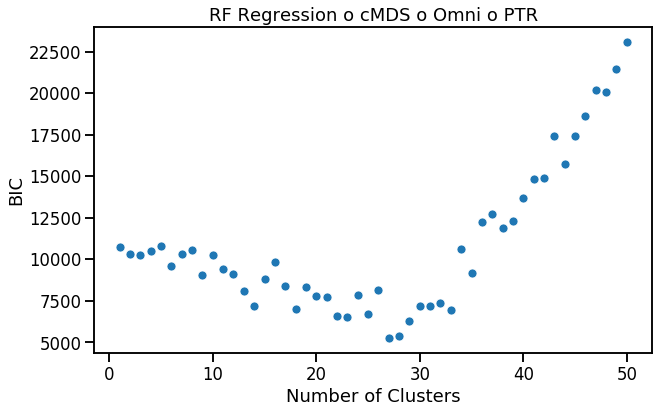

In [45]:
plot_scatter(np.arange(1, 51), gclust.ari_, ylabel='ARI', xlabel='Number of Clusters', title = 'RF Regression o cMDS o Omni o PTR')

plot_scatter(np.arange(1, 51), gclust.bic_, ylabel='BIC', xlabel='Number of Clusters', title = 'RF Regression o cMDS o Omni o PTR')

In [46]:
mgc_independence = MGC(X_rf_regress, age.astype(float), None)
pval, data = mgc_independence.p_value()

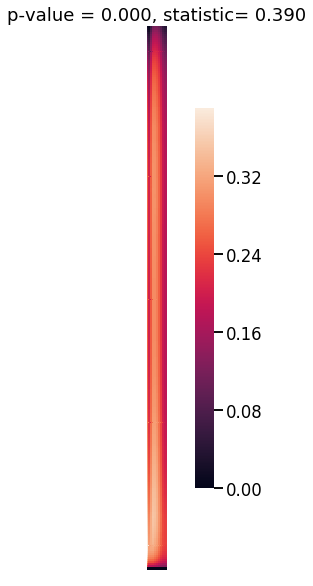

In [47]:
corr_matrix = data['local_correlation_matrix']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot = sns.heatmap(np.flipud(corr_matrix), ax=ax, square=True, cbar_kws = dict(shrink=0.7), xticklabels=False,
            yticklabels=False)
    plot.set_title('p-value = {:.3f}, statistic= {:.3f}'.format(pval, data['test_statistic']))

In [49]:
len(dmri_ptr)

274

In [62]:
idx = np.tril_indices_from(fmri_ptr[0])

In [65]:
dmri_vec = [g[idx] for g in dmri_ptr]
fmri_vec = [g[idx] for g in fmri_ptr]

dmri_vec = np.stack(dmri_vec)
fmri_vec = np.stack(fmri_vec)

mri_vec = np.hstack([dmri_vec, fmri_vec])

In [68]:
lr = LinearRegression()
lr.fit(age, mri_vec)
predictions = lr.predict(age)

X_vec_regressed = mri_vec - predictions

In [70]:
warnings.filterwarnings('ignore')

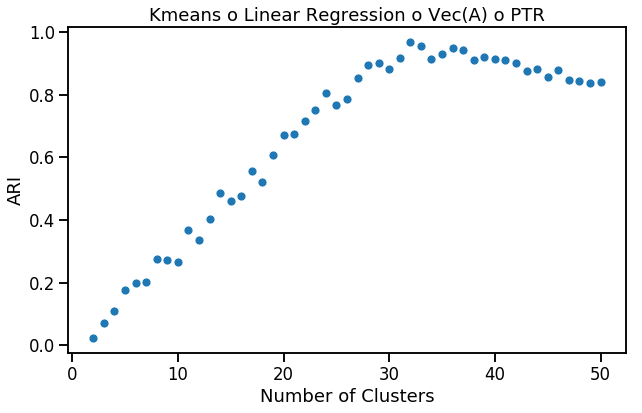

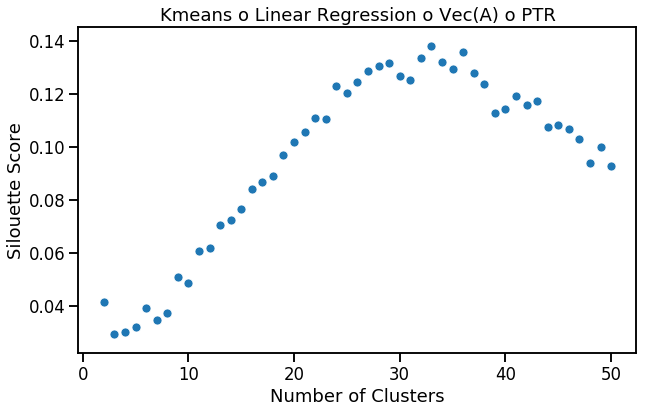

In [84]:
kclust = gs.cluster.KMeansCluster(50)
kclust.fit(X_vec_regressed, labels)

plot_scatter(np.arange(2, 51), kclust.ari_, ylabel='ARI', xlabel='Number of Clusters', 
             title = 'Kmeans o Linear Regression o Vec(A) o PTR')

plot_scatter(np.arange(2, 51), kclust.silhouette_, ylabel='Silouette Score', xlabel='Number of Clusters', 
             title = 'Kmeans o Linear Regression o Vec(A) o PTR')

In [78]:
rf = RandomForestRegressor(n_estimators=500)

rf.fit(age, mri_vec)
predictions = rf.predict(age)

X_vec_rf = mri_vec - predictions

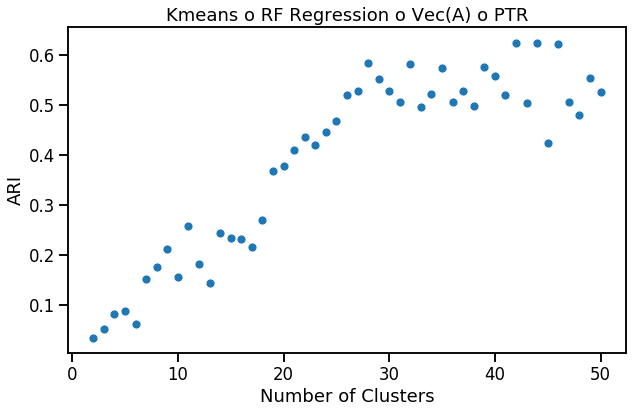

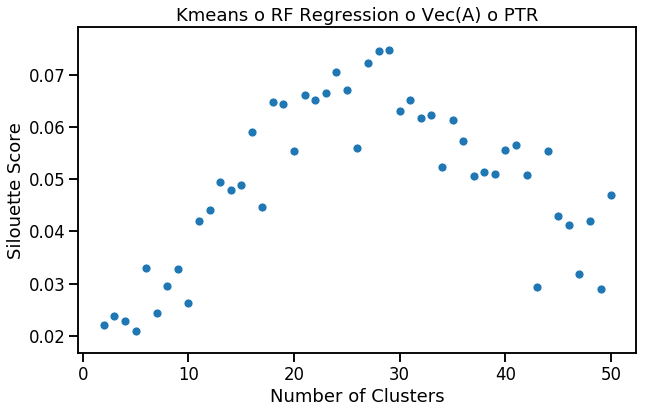

In [85]:
kclust = gs.cluster.KMeansCluster(50)
kclust.fit(X_vec_rf, labels)

plot_scatter(np.arange(2, 51), kclust.ari_, ylabel='ARI', xlabel='Number of Clusters', 
             title = 'Kmeans o RF Regression o Vec(A) o PTR')

plot_scatter(np.arange(2, 51), kclust.silhouette_, ylabel='Silouette Score', xlabel='Number of Clusters', 
             title = 'Kmeans o RF Regression o Vec(A) o PTR')

## Test individual modality

### Test dMRI